In [143]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
import numpy as np 
import matplotlib.pyplot as plt 
from ECD_control.ECD_pulse_construction.ECD_pulse_construction import *
from ECD_control.ECD_tools.ECD_tools import *
import qutip as qt

In [145]:
#the parameters in our circuit. Can be user defined, or loaded from the result of an ECD optimization.
betas = np.array([0.3, 1j*np.sqrt(2*np.pi), 0.3, 0])
phis = np.pi*np.array([np.pi/2.0, 0, 0, -np.pi/2.0])
thetas = np.pi*np.array([np.pi/2.0, -np.pi/2.0, np.pi/2.0, np.pi/2.0])
print('betas:' + str(betas))
print('phis:' + str(phis))
print('thetas:' + str(thetas))

betas:[0.3+0.j         0. +2.50662827j 0.3+0.j         0. +0.j        ]
phis:[ 4.9348022  0.         0.        -4.9348022]
thetas:[ 4.9348022 -4.9348022  4.9348022  4.9348022]


the circuit:
betas: [0.3+0.j         0. +2.50662827j 0.3+0.j         0. +0.j        ]
phis deg: [ 282.74333882    0.            0.         -282.74333882]
thetas deg: [ 282.74333882 -282.74333882  282.74333882  282.74333882]


Text(0.5, 1.0, 'unitary sim')

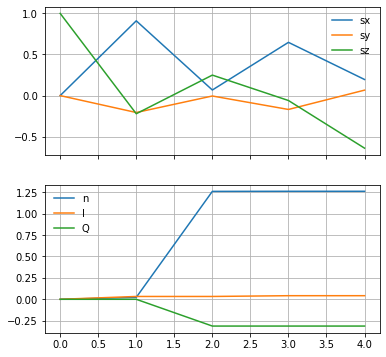

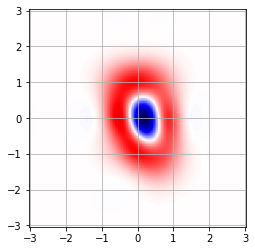

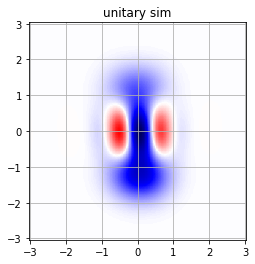

In [146]:
#Now, the unitary simulation
print('the circuit:')
print('betas: ' + str(betas))
print('phis deg: ' + str(180*phis/np.pi))
print('thetas deg: ' + str(180*thetas/np.pi))
N = 40
psi0 = qt.tensor(qt.basis(2,0),qt.basis(N,0))
#psit = qt.tensor(qt.basis(2,1),qt.basis(N,fock))
psis = unitary_circuit_sim(psi0, betas, phis, thetas, N)
psif = psis[-1]
plot_expect(psis)
g = qt.tensor(qt.basis(2,0), qt.identity(N))
e = qt.tensor(qt.basis(2,1), qt.identity(N))
psi_g = (g.dag()*psif).unit()
psi_e = (e.dag()*psif).unit()
xvec = np.linspace(-3,3,81)
plot_wigner(psi_g, xvec)
plot_wigner(psi_e, xvec, invert=True)
plt.title('unitary sim')

In [148]:
#Our cavity and qubit. When using pulse construction on the FPGA, these objects can be loaded, and 
#the pre-calibrated values can be used. Here, we are making a "FakeCavity" and a "FakeQubit" in order
#to demonstrate the pulse construction when not connected to the FPGA_lib.

#The following parameters are assumed to be defined under your cavity and qubit entity object in FPGA lib.
storage_params = {'chi_kHz': -191., 'chi_prime_Hz': -135., 'Ks_Hz': -81.5, 'epsilon_m_MHz': 0, 'unit_amp': 0.046384, 'sigma': 4, 'chop': 4}
qubit_params = {'unit_amp': 0.684312, 'sigma': 4, 'chop': 4}

#calculating epsilon m
wave = storage_params['unit_amp']*gaussian_wave(storage_params['sigma'], storage_params['chop'])
epsilon_m = 1/np.trapz(wave)
epsilon_m_MHz = 1e3*epsilon_m/2/np.pi
print('epsilon_m_MHz: %.6f' % epsilon_m_MHz)
storage_params['epsilon_m_MHz'] = epsilon_m_MHz

pi = rotate(np.pi, phi=0, sigma=qubit_params['sigma'], chop=qubit_params['chop'], dt=1)
Omega_m = np.real(np.max(pi))/qubit_params['unit_amp']

#creating the "Fake storage" and "Fake qubit"
storage = FakeStorage(**storage_params)
qubit = FakeQubit(**qubit_params)

#The alpha used during the ECD gates.
alpha_CD = 8
#Buffer time between R and ECD pulses.
buffer_time = 4

epsilon_m_MHz: 428.113770


In [149]:
#generating the conditional displacement circuit with all corrections.
cd_circuit_dict = conditional_displacement_circuit(betas, phis, thetas, storage, qubit,
                     alpha_CD,  buffer_time=buffer_time, kerr_correction = False, chi_prime_correction=True, final_disp=True, pad=True)
cavity_dac_pulse, qubit_dac_pulse, = cd_circuit_dict['cavity_dac_pulse'], cd_circuit_dict['qubit_dac_pulse']

C:\ProgramData\Miniconda3\envs\opt3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


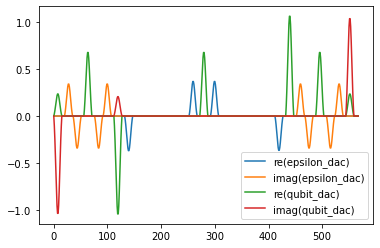

In [150]:
#plotting the pulse
plt.plot(np.real(cavity_dac_pulse), label='re(epsilon_dac)')
plt.plot(np.imag(cavity_dac_pulse), label='imag(epsilon_dac)')
plt.plot(np.real(qubit_dac_pulse), label='re(qubit_dac)')
plt.plot(np.imag(qubit_dac_pulse), label='imag(qubit_dac)')
plt.legend()

In [155]:
N = 40
N2 = 3 
rho0 = qt.tensor(qt.basis(N2,0),qt.basis(N,0))

chi = 2*np.pi*1e-6*storage_params['chi_kHz']
chi_prime = 2*np.pi*1e-9*storage_params['chi_prime_Hz']
Ks = 2*np.pi*1e-9*storage_params['Ks_Hz']
#delta_error = -2*np.pi*1e-9*5000
delta_error = 0
delta = -chi/2.0 + delta_error
#vlad's anharmonicity
Kq = -2 * np.pi * 1e-3 * 2 * 200
kappa = 1/(550.0e3)
gamma_down_qubit = 1/(110.0e3)
#I know this is not quite correct but let's try it
T2E = 100.0e3
gamma_2 = 1/T2E
gamma_phi_qubit = gamma_2 - gamma_down_qubit/2.0
#
#doing master equation simulation
epsilon = 2*np.pi*1e-3*storage_params['epsilon_m_MHz']*cavity_dac_pulse
Omega = Omega_m*qubit_dac_pulse
me_options = {'Kq':Kq, 'delta':delta, 'chi':chi,
    'chi_prime':chi_prime, 'Ks':Ks, 'kappa':kappa, 'gamma_down_qubit':gamma_down_qubit,
    'gamma_phi_qubit':gamma_phi_qubit, 'output':True}
result, alpha = simulate_master_equation(epsilon = 1j*epsilon,rho0=rho0,Omega=1j*Omega, **me_options)

Solving for alpha(t)
Constructing Hamiltonian
Running mesolve:
10.0%. Run time:   4.70s. Est. time left: 00:00:00:42
20.1%. Run time:   9.26s. Est. time left: 00:00:00:36
30.1%. Run time:  13.58s. Est. time left: 00:00:00:31
40.1%. Run time:  17.96s. Est. time left: 00:00:00:26
50.0%. Run time:  23.84s. Est. time left: 00:00:00:23
60.0%. Run time:  30.51s. Est. time left: 00:00:00:20
70.1%. Run time:  37.00s. Est. time left: 00:00:00:15
80.1%. Run time:  43.48s. Est. time left: 00:00:00:10
90.1%. Run time:  50.28s. Est. time left: 00:00:00:05
Total run time:  56.59s


In [156]:
#rhof = qt.ket2dm(result.states[-1])
rhof = result.states[-1]
g = qt.tensor(qt.basis(N2,0), qt.identity(N))
e = qt.tensor(qt.basis(N2,1), qt.identity(N))
rhof_g = (g.dag()*rhof*g).unit()
rhof_e = (e.dag()*rhof*e).unit()
#correct final frame
D =  qt.displace(N,alpha[-1])
rhof_g =D*rhof_g*D.dag()
rhof_e =D*rhof_e*D.dag()

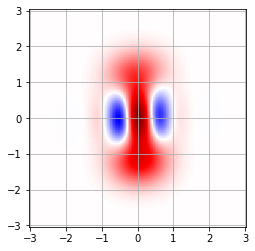

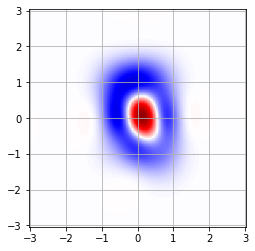

In [157]:
plot_wigner(rhof_g, xvec)
plot_wigner(-1*rhof_e, xvec)

In [158]:
fid_g = qt.fidelity(rhof_g, psi_e)
fid_e = qt.fidelity(rhof_e, psi_g)
print('fid g: %.6f fid e: %.6f' % (fid_g, fid_e))

fid g: 0.993813 fid e: 0.984680
